In [19]:
# Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modules for Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [20]:
# Importing the dataset
df = pd.read_csv('PlayersFBREF.csv')
print(f"Original dataset shape: {df.shape}")
df.head()

Original dataset shape: (2274, 34)


,Unnamed: 0,Player,Nation,Position,Age,Matches Played,Starts,Minutes,90s Played,Goals,...,Goals Per 90,Assists Per 90,Goals + Assists Per 90,Non-Penalty Goals Per 90,Non-Penalty Goals + Assists Per 90,xG Per 90,xAG Per 90,xG + xAG Per 90,npxG Per 90,npxG + xAG Per 90
0,0,Mohamed Salah,EGY,AT,32,38,38,"3,371",37.5,29,...,0.77,0.48,1.25,0.53,1.01,0.67,0.38,1.05,0.49,0.87
1,1,Virgil van Dijk,NED,DF,33,37,37,"3,330",37.0,3,...,0.08,0.03,0.11,0.08,0.11,0.06,0.02,0.08,0.06,0.08
2,2,Ryan Gravenberch,NED,MT,22,37,37,"3,160",35.1,0,...,0.00,0.11,0.11,0.00,0.11,0.03,0.09,0.12,0.03,0.12
3,3,Alexis Mac Allister,ARG,MT,25,35,30,"2,599",28.9,5,...,0.17,0.17,0.35,0.17,0.35,0.10,0.16,0.26,0.10,0.26
4,4,Ibrahima Konaté,FRA,DF,25,31,30,"2,560",28.4,1,...,0.04,0.07,0.11,0.04,0.11,0.06,0.03,0.10,0.06,0.10


In [21]:
print("--- CLEANING DATA ---")

# 1. Remove Duplicates
df_clean = df.drop_duplicates(subset=['Player']).copy()
print(f"1. Removed duplicates. Count: {df_clean.shape[0]}")

# 2. Fix 'Minutes' (Remove commas, convert to number)
df_clean['Minutes'] = pd.to_numeric(df_clean['Minutes'].astype(str).str.replace(',', ''), errors='coerce')

# 3. Filter Noise (Players with < 450 Minutes)
df_clean = df_clean[df_clean['Minutes'] >= 450].copy()
print(f"2. Filtered low minutes (<450 min). Count: {df_clean.shape[0]}")

# 4. Standardize Positions
df_clean['Primary_Pos'] = df_clean['Position'].apply(lambda x: x.split(',')[0])
df_clean['Primary_Pos'] = df_clean['Primary_Pos'].replace({
    'GB': 'GK', 'MT': 'MF', 'AT': 'FW'
})

# 5. DROP UNNECESSARY COLUMNS (New Step)
# We only keep the columns we need for AI + Player Name for reference
cols_to_keep = [
    'Player', 'Primary_Pos', 
    'Goals Per 90', 'Assists Per 90', 'xG Per 90', 
    'npxG + xAG Per 90', 'Progressive Carries', 
    'Progressive Passes', 'Yellow Cards'
]

# Overwrite df_clean with ONLY these columns
df_clean = df_clean[cols_to_keep].copy()

print(f"3. Dropped unused columns. Final Shape: {df_clean.shape}")
print("   Columns remaining:", list(df_clean.columns))
df_clean.head()

--- CLEANING DATA ---
1. Removed duplicates. Count: 1991
2. Filtered low minutes (<450 min). Count: 1401
3. Dropped unused columns. Final Shape: (1401, 9)
   Columns remaining: ['Player', 'Primary_Pos', 'Goals Per 90', 'Assists Per 90', 'xG Per 90', 'npxG + xAG Per 90', 'Progressive Carries', 'Progressive Passes', 'Yellow Cards']


,Player,Primary_Pos,Goals Per 90,Assists Per 90,xG Per 90,npxG + xAG Per 90,Progressive Carries,Progressive Passes,Yellow Cards
0,Mohamed Salah,FW,0.77,0.48,0.67,0.87,154,144,1
1,Virgil van Dijk,DF,0.08,0.03,0.06,0.08,22,198,5
2,Ryan Gravenberch,MF,0.00,0.11,0.03,0.12,70,181,6
3,Alexis Mac Allister,MF,0.17,0.17,0.10,0.26,36,177,6
4,Ibrahima Konaté,DF,0.04,0.07,0.06,0.10,25,115,5


In [22]:
# --- CELL 4: Feature Selection & Scaling ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Select Features
feature_cols = [
    'Goals Per 90', 'Assists Per 90', 'xG Per 90',
    'npxG + xAG Per 90', 'Progressive Carries',
    'Progressive Passes', 'Yellow Cards'
]

X = df_clean[feature_cols].fillna(0)
y = df_clean['Primary_Pos']

# 2. Split Data (THIS DEFINES y_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Scaling Complete. y_test is now ready.")

Data Scaling Complete. y_test is now ready.


Training KNN...

>> KNN Accuracy: 70.11%
              precision    recall  f1-score   support

          DF       0.66      0.74      0.70       110
          FW       0.85      0.68      0.75        34
          GK       1.00      0.94      0.97        35
          MF       0.61      0.59      0.60       102

    accuracy                           0.70       281
   macro avg       0.78      0.74      0.75       281
weighted avg       0.71      0.70      0.70       281



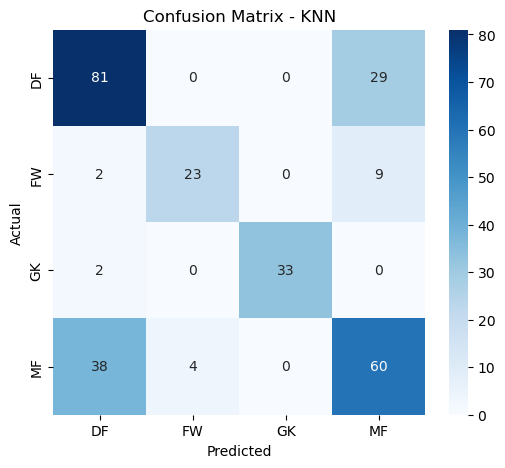

In [23]:
# --- KNN MODEL ---
print("Training KNN...")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# Predict
knn_pred = knn_model.predict(X_test_scaled)
acc_knn = accuracy_score(y_test, knn_pred)

# Output Text
print(f"\n>> KNN Accuracy: {acc_knn:.2%}")
print(classification_report(y_test, knn_pred))

# Output Graph
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, knn_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)
plt.title('Confusion Matrix - KNN')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Training SVM...

>> SVM Accuracy: 79.00%
              precision    recall  f1-score   support

          DF       0.73      0.87      0.79       110
          FW       0.90      0.79      0.84        34
          GK       0.97      1.00      0.99        35
          MF       0.77      0.63      0.69       102

    accuracy                           0.79       281
   macro avg       0.84      0.82      0.83       281
weighted avg       0.79      0.79      0.79       281



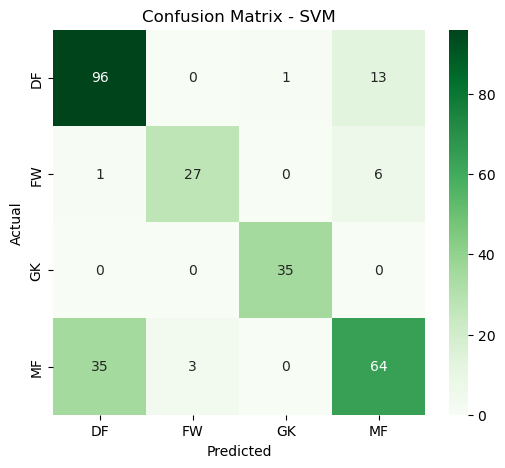

In [24]:
# --- SVM MODEL ---
print("Training SVM...")
# probability=True is required for ROC curves
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predict
svm_pred = svm_model.predict(X_test_scaled)
acc_svm = accuracy_score(y_test, svm_pred)

# Output Text
print(f"\n>> SVM Accuracy: {acc_svm:.2%}")
print(classification_report(y_test, svm_pred))

# Output Graph (Green)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title('Confusion Matrix - SVM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Training Random Forest...

>> Random Forest Accuracy: 76.87%
              precision    recall  f1-score   support

          DF       0.74      0.82      0.78       110
          FW       0.81      0.74      0.77        34
          GK       1.00      1.00      1.00        35
          MF       0.70      0.65      0.67       102

    accuracy                           0.77       281
   macro avg       0.81      0.80      0.81       281
weighted avg       0.77      0.77      0.77       281



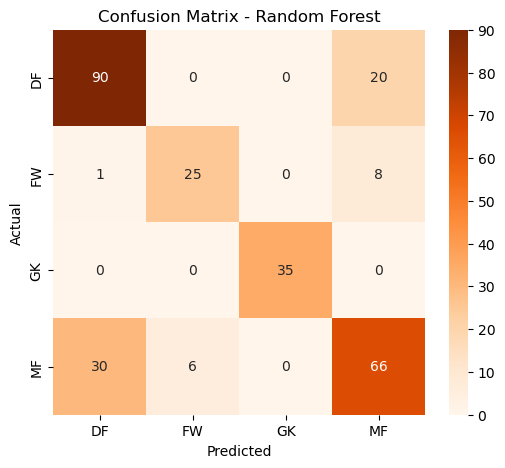

In [25]:
# --- RANDOM FOREST MODEL ---
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict
rf_pred = rf_model.predict(X_test_scaled)
acc_rf = accuracy_score(y_test, rf_pred)

# Output Text
print(f"\n>> Random Forest Accuracy: {acc_rf:.2%}")
print(classification_report(y_test, rf_pred))

# Output Graph (Orange)
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

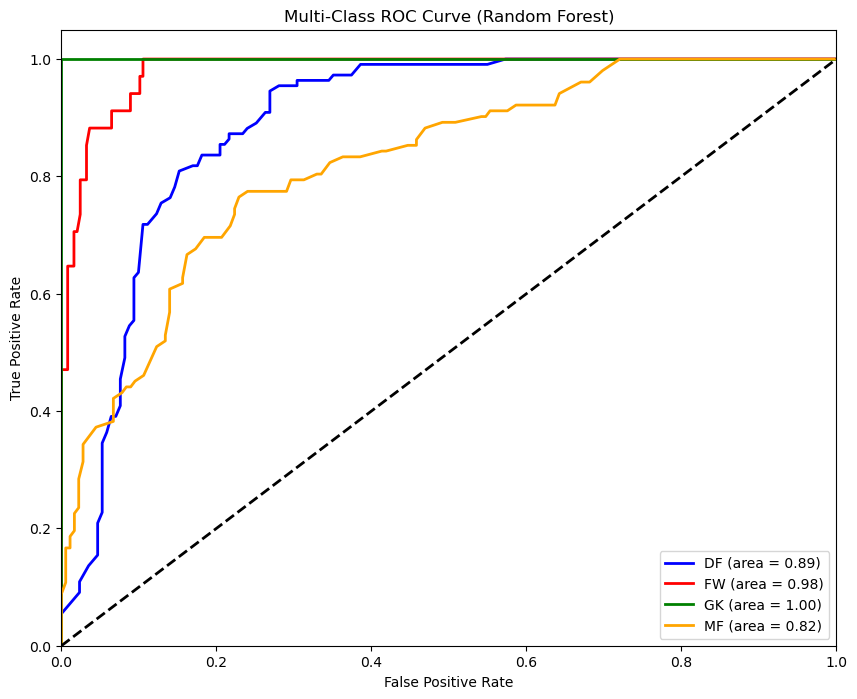

In [26]:
# --- ROC CURVE ANALYSIS ---
# Imports needed specifically for this chart
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Setup
classes = rf_model.classes_
# y_test must be defined from previous steps (Cell 4)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# 2. Get Probabilities
y_score = rf_model.predict_proba(X_test_scaled)

# 3. Compute Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (Random Forest)')
plt.legend(loc="lower right")
plt.show()

In [31]:
# --- CROSS-VALIDATION ANALYSIS (Self-Contained) ---
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# 1. RE-DEFINE VARIABLES (To prevent NameError)
# We make sure X and y exist right here, right now.
feature_cols = [
    'Goals Per 90', 'Assists Per 90', 'xG Per 90', 
    'npxG + xAG Per 90', 'Progressive Carries', 
    'Progressive Passes', 'Yellow Cards'
]

# Ensure df_clean exists (if not, use df)
if 'df_clean' in locals():
    data_source = df_clean
else:
    # Fallback if cleaning cell wasn't run (using raw df but filtering)
    data_source = df[df['Minutes'] >= 450].copy()
    data_source['Primary_Pos'] = data_source['Position'].apply(lambda x: x.split(',')[0])
    data_source['Primary_Pos'] = data_source['Primary_Pos'].replace({'GB': 'GK', 'MT': 'MF', 'AT': 'FW'})

X_cv = data_source[feature_cols].fillna(0)
y_cv = data_source['Primary_Pos']

# 2. Define Models
cv_models = [
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('SVM', SVC(kernel='rbf')),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42))
]

# 3. Setup Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = []
names = []

print("Running 10-Fold Cross-Validation...")
print("-" * 40)

# 4. Run Loop
for name, model in cv_models:
    # Pipeline handles scaling automatically for every fold
    pipeline = make_pipeline(StandardScaler(), model)
    
    # We use X_cv and y_cv here
    cv_scores = cross_val_score(pipeline, X_cv, y_cv, cv=kfold, scoring='accuracy')
    
    results.append(cv_scores)
    names.append(name)
    
    print(f"{name}: Mean Accuracy = {cv_scores.mean():.2%} (+/- {cv_scores.std():.2%})")


Running 10-Fold Cross-Validation...
----------------------------------------
KNN: Mean Accuracy = 70.59% (+/- 3.96%)
SVM: Mean Accuracy = 76.16% (+/- 3.49%)
Random Forest: Mean Accuracy = 74.80% (+/- 3.22%)


--- Performance Summary ---
       Algorithm  Accuracy
1            SVM  0.790036
2  Random Forest  0.768683
0            KNN  0.701068


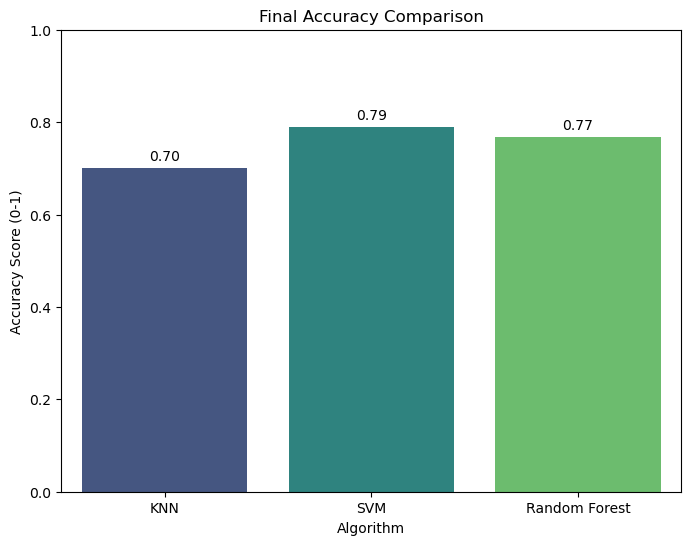

In [30]:
# --- 10. FINAL MODEL COMPARISON ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Gather scores from previous cells
try:
    model_scores = {
        'KNN': acc_knn,
        'SVM': acc_svm,
        'Random Forest': acc_rf
    }
except NameError:
    print("⚠️ Error: You must run the KNN, SVM, and Random Forest cells above first!")
    model_scores = {}

if model_scores:
    # 2. Create DataFrame for Plotting
    comparison_df = pd.DataFrame(list(model_scores.items()), columns=['Algorithm', 'Accuracy'])
    
    # 3. Print Data Table
    print("--- Performance Summary ---")
    print(comparison_df.sort_values(by='Accuracy', ascending=False))

    # 4. Visualize with Bar Chart
    plt.figure(figsize=(8, 6))
    
    # FIX: Added hue='Algorithm' and legend=False to fix the warning
    ax = sns.barplot(x='Algorithm', y='Accuracy', data=comparison_df, 
                     hue='Algorithm', palette='viridis', legend=False)
    
    # Add labels on top of bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=3)

    plt.ylim(0, 1.0) # Scale from 0 to 100%
    plt.title('Final Accuracy Comparison')
    plt.ylabel('Accuracy Score (0-1)')
    plt.show()